# Crash Data 2009


"How accurate can a machine learning model predict the total number of crashes for a certain California county based on a given year?"

In [ ]:
!pip install  geopandas

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
#import openpyxl
import csv
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Load 2009 crash data & 2010 test data (per county report)

In [3]:
df = pd.read_csv('crash_data_2009.csv')

C:\Users\oband\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (25,26,37,47,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,3858022,1005.0,P379,2C,not chp,>250000,1005,fresno,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-03,17:11:00,2009-04-27
1,3899441,9120.0,17248,NaN,2200 thru 0559,2500 to 10000,801,del norte,0,chp state highway,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-28,01:45:00,2009-11-02
2,3899442,9530.0,19005,NaN,0600 thru 1359,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.86465,-118.28533,2009-02-09,10:20:00,2010-01-14
3,3899445,9530.0,19284,NaN,1400 thru 2159,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.79120,-118.28230,2009-02-18,15:50:00,2010-01-13
4,3899446,9530.0,19289,NaN,1400 thru 2159,25000 to 50000,1939,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.88450,-118.35260,2009-02-11,17:35:00,2010-01-11


In [ ]:
for i in df.columns:
    print(i, df[i].unique(), '\n----------------------')

In [39]:
#add: intersection, motor_vehicle_involved_with , side_of_highway , 
#add: location_type(contains intersection)
crashes = df[["county_location", "collision_time","population",  'alcohol_involved',"weather_1", "lighting", "road_surface", "road_condition_1", "state_highway_indicator","type_of_collision", "party_count", "collision_severity"]]

In [40]:
crashes.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17:11:00,>250000,NaN,clear,daylight,dry,normal,0.0,rear end,2,property damage only
1,del norte,01:45:00,2500 to 10000,NaN,clear,dark with no street lights,dry,normal,1.0,hit object,1,property damage only
2,los angeles,10:20:00,>250000,NaN,raining,daylight,wet,normal,1.0,sideswipe,2,property damage only
3,los angeles,15:50:00,>250000,NaN,clear,daylight,dry,normal,1.0,sideswipe,3,property damage only
4,los angeles,17:35:00,25000 to 50000,NaN,cloudy,dusk or dawn,dry,normal,1.0,rear end,3,property damage only


In [41]:
crashes.isna().sum()


county_location                 0
collision_time               3766
population                      0
alcohol_involved           380305
weather_1                    2368
lighting                     2915
road_surface                 4196
road_condition_1             3826
state_highway_indicator        63
type_of_collision            3969
party_count                     0
collision_severity              0
dtype: int64

In [42]:
crashes = crashes[crashes['road_condition_1'] != 'other']
crashes = crashes[crashes['weather_1'] != 'other']

In [43]:
crashes['alcohol_involved'] = crashes['alcohol_involved'].fillna(0)

In [44]:
columns_to_encode = ['collision_severity', 'weather_1', 'state_highway_indicator',
                     'lighting', 'road_surface', 'road_condition_1','population','type_of_collision']
crashes_encoded = crashes.copy()
def encodeCategorical(list_columns):
    labelencoder = LabelEncoder()
    for col in list_columns:
        #drop na in original as well
        crashes.dropna(subset=[col], inplace=True)
        
        crashes_encoded.dropna(subset=[col], inplace=True)
        di = {}
        for i in np.arange(len(crashes_encoded[col].unique())):
            di[crashes_encoded[col].unique()[i]] = i 
        crashes_encoded.replace({col: di},inplace=True)
            
        #crashes_encoded[col] = labelencoder.fit_transform(crashes_encoded[col])
encodeCategorical(columns_to_encode)

In [45]:
#get hour out of collision time
crashes.dropna(subset=['collision_time'], inplace=True)
crashes_encoded.dropna(subset=['collision_time'], inplace=True)

#crashes_encoded.dropna(subset=['collision_time'], inplace=True)
times = []
for full_time in crashes.collision_time:
    times.append(int(full_time[:2]))
crashes.collision_time = times
crashes_encoded.collision_time = times
    


In [46]:
crashes_encoded.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,0,0.0,0,0,0,0,0.0,0,2,0
1,del norte,1,1,0.0,0,1,0,0,1.0,1,1,0
2,los angeles,10,0,0.0,1,0,1,0,1.0,2,2,0
3,los angeles,15,0,0.0,0,0,0,0,1.0,2,3,0
4,los angeles,17,2,0.0,2,2,0,0,1.0,0,3,0


In [47]:
crashes.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,>250000,0.0,clear,daylight,dry,normal,0.0,rear end,2,property damage only
1,del norte,1,2500 to 10000,0.0,clear,dark with no street lights,dry,normal,1.0,hit object,1,property damage only
2,los angeles,10,>250000,0.0,raining,daylight,wet,normal,1.0,sideswipe,2,property damage only
3,los angeles,15,>250000,0.0,clear,daylight,dry,normal,1.0,sideswipe,3,property damage only
4,los angeles,17,25000 to 50000,0.0,cloudy,dusk or dawn,dry,normal,1.0,rear end,3,property damage only


In [48]:
#wet = 4, dry = 0
crashes['collision_severity'].unique()

array(['property damage only', 'pain', 'severe injury', 'other injury',
       'fatal'], dtype=object)

In [49]:
crashes_encoded['collision_severity'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [50]:
crashes.isna().sum()

county_location            0
collision_time             0
population                 0
alcohol_involved           0
weather_1                  0
lighting                   0
road_surface               0
road_condition_1           0
state_highway_indicator    0
type_of_collision          0
party_count                0
collision_severity         0
dtype: int64

In [51]:
crashes_encoded.isna().sum()

county_location            0
collision_time             0
population                 0
alcohol_involved           0
weather_1                  0
lighting                   0
road_surface               0
road_condition_1           0
state_highway_indicator    0
type_of_collision          0
party_count                0
collision_severity         0
dtype: int64

# Data Exploration
- Proportion of severe injuries
   - when alcohol is involved
   - when weather is raining/cloudy
   - when lighting is dark with no street lights
   - when road_surface is wet

In [22]:
crashes.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,>250000,0.0,clear,daylight,dry,normal,0.0,rear end,2,property damage only
1,del norte,1,2500 to 10000,0.0,clear,dark with no street lights,dry,normal,1.0,hit object,1,property damage only
2,los angeles,10,>250000,0.0,raining,daylight,wet,normal,1.0,sideswipe,2,property damage only
3,los angeles,15,>250000,0.0,clear,daylight,dry,normal,1.0,sideswipe,3,property damage only
4,los angeles,17,25000 to 50000,0.0,cloudy,dusk or dawn,dry,normal,1.0,rear end,3,property damage only


In [23]:
crashes_encoded['collision_severity'].value_counts()

0    249379
1    100257
3     49301
2      9053
4      2723
Name: collision_severity, dtype: int64

In [ ]:
crashes.collision_severity

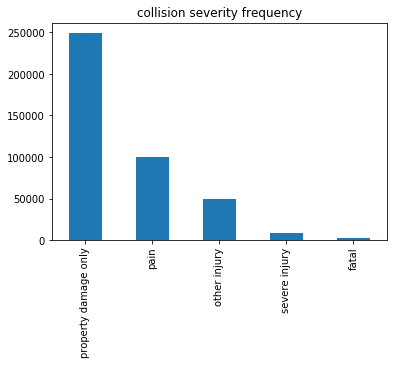

In [24]:
crashes.collision_severity.value_counts().plot(kind='bar', title="collision severity frequency");

In [79]:

new_ranks = []
crashes_encoded_severity = crashes_encoded.copy()
for rank in crashes_encoded.collision_severity:
    if (rank==1):
        new_ranks.append(1)
    elif (rank==3):
        new_ranks.append(1)
    elif (rank==2):
        new_ranks.append(2)
    elif (rank==4):
        new_ranks.append(2)
    else:
        new_ranks.append(0)


In [80]:
crashes_encoded_severity.collision_severity = new_ranks
crashes_encoded_severity.collision_severity.unique()

array([0, 1, 2], dtype=int64)

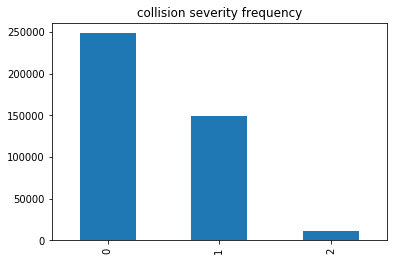

In [81]:
crashes_encoded_severity.collision_severity.value_counts().plot(kind='bar', title="collision severity frequency");

In [28]:
crashes_encoded.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,0,0.0,0,0,0,0,0.0,0,2,0
1,del norte,1,1,0.0,0,1,0,0,1.0,1,1,0
2,los angeles,10,0,0.0,1,0,1,0,1.0,2,2,0
3,los angeles,15,0,0.0,0,0,0,0,1.0,2,3,0
4,los angeles,17,2,0.0,2,2,0,0,1.0,0,3,0


In [29]:
crashes_severe = crashes_encoded[crashes_encoded['collision_severity']>1]
crashes_severe

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
25,los angeles,15,3,1.0,0,0,0,0,0.0,4,4,2
30,los angeles,13,0,0.0,0,0,0,0,1.0,1,1,3
72,los angeles,17,5,1.0,0,0,0,0,0.0,4,2,2
78,los angeles,8,5,0.0,0,0,0,0,0.0,4,2,3
93,los angeles,18,5,0.0,0,3,0,0,0.0,4,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
426209,san bernardino,18,5,1.0,0,3,0,0,0.0,4,2,3
426212,san bernardino,7,5,0.0,2,0,1,0,1.0,1,1,2
426213,san bernardino,18,5,0.0,0,3,0,0,0.0,3,2,2
426215,mendocino,11,1,0.0,0,0,0,0,1.0,4,2,3


In [30]:
crashes_alc_severe = crashes_severe.groupby(['alcohol_involved'])['alcohol_involved'].count()
crashes_alc_severe

alcohol_involved
0.0    49446
1.0    11631
Name: alcohol_involved, dtype: int64

percent of severe accidents involving alcohol : 0.24%


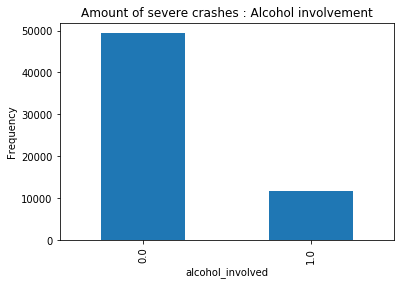

In [31]:
crashes_alc_severe.plot(kind='bar', title='Amount of severe crashes : Alcohol involvement');
plt.ylabel('Frequency');
print('percent of severe accidents involving alcohol : '
      + str(round(crashes_alc_severe[1]/crashes_alc_severe[0], 2)) + '%')

In [32]:
crashes_sh_severe = crashes_severe[crashes_severe['state_highway_indicator']==1]
crashes_sh_severe

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
30,los angeles,13,0,0.0,0,0,0,0,1.0,1,1,3
99,san diego,5,3,1.0,0,1,0,0,1.0,7,1,3
121,san bernardino,2,5,1.0,0,3,0,0,1.0,1,1,4
123,san bernardino,13,5,0.0,0,0,0,0,1.0,1,2,4
126,sacramento,11,3,0.0,0,0,0,0,1.0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
425852,san bernardino,13,5,0.0,2,0,1,0,1.0,7,1,3
425888,fresno,8,1,0.0,2,0,2,0,1.0,0,2,3
426053,san joaquin,9,5,0.0,0,0,0,0,1.0,4,3,3
426212,san bernardino,7,5,0.0,2,0,1,0,1.0,1,1,2


In [33]:
crashes_sh_severe = crashes_severe.groupby(['state_highway_indicator'])['state_highway_indicator'].count()
crashes_sh_severe

state_highway_indicator
0.0    41568
1.0    19509
Name: state_highway_indicator, dtype: int64

percent of severe accidents on State Highways : 0.47%


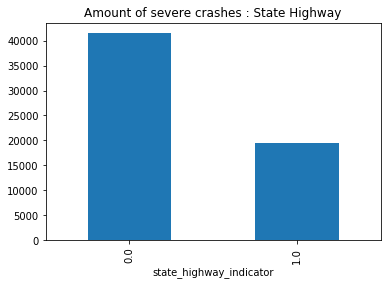

In [34]:
crashes_sh_severe.plot(kind='bar', title='Amount of severe crashes : State Highway');
print('percent of severe accidents on State Highways : '
      + str(round(crashes_sh_severe[1]/crashes_sh_severe[0], 2)) + '%')

['clear' 'raining' 'cloudy' 'fog' 'snowing' 'wind' 'other']


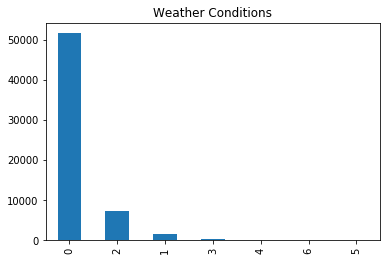

In [35]:
#shows the most prevelant weather conditions during severe injuries are : rain and cloudy
crashes_severe['weather_1'].value_counts().plot(kind='bar', title='Weather Conditions');
print(crashes.weather_1.unique())

In [50]:
(late_night_crashes['collision_severity'].value_counts()[1] + late_night_crashes['collision_severity'].value_counts()[2]) / late_night_crashes['collision_severity'].value_counts().sum()

0.39602156495056257

percent of high rank accidents at night (after 7pm) : 40.0%


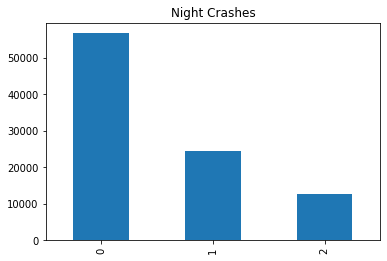

In [54]:
late_night_crashes = crashes_encoded_severity[crashes_encoded_severity['collision_time'] >=18]
late_night_crashes['collision_severity'].value_counts().plot(kind='bar', title='Night Crashes')
print('percent of high rank accidents at night (after 7pm) : '
      + str(round((late_night_crashes['collision_severity'].value_counts()[1] 
                   + late_night_crashes['collision_severity'].value_counts()[2]) 
                  / late_night_crashes['collision_severity'].value_counts().sum(), 2)*100) + '%')

# Modeling
-Random Forest

In [82]:
crashes_encoded_severity

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,0,0.0,0,0,0,0,0.0,0,2,0
1,del norte,1,1,0.0,0,1,0,0,1.0,1,1,0
2,los angeles,10,0,0.0,1,0,1,0,1.0,2,2,0
3,los angeles,15,0,0.0,0,0,0,0,1.0,2,3,0
4,los angeles,17,2,0.0,2,2,0,0,1.0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
426223,san bernardino,8,5,0.0,2,0,0,0,0.0,0,2,1
426224,san bernardino,16,5,0.0,2,2,0,0,0.0,0,3,1
426225,san bernardino,9,5,0.0,0,0,0,0,0.0,0,3,1
426226,san bernardino,19,5,0.0,0,3,0,0,0.0,4,2,0


In [26]:
#add: intersection, motor_vehicle_involved_with , side_of_highway , 
#add: location_type(contains intersection)
crashes_model = df[["county_location", "collision_time","population",  'alcohol_involved',"weather_1", "lighting", "road_surface", "road_condition_1", "state_highway_indicator","type_of_collision", "party_count", "collision_severity"]]


In [27]:
crashes_model['alcohol_involved'] = crashes_model['alcohol_involved'].fillna(0)

C:\Users\oband\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
columns_to_encode = ['collision_severity','state_highway_indicator','population','type_of_collision']
crashes_model_encoded = crashes_model.copy()
def encodeCategorical(list_columns):
    labelencoder = LabelEncoder()
    for col in list_columns:
        #drop na in original as well
        crashes_model.dropna(subset=[col], inplace=True)
        
        crashes_model_encoded.dropna(subset=[col], inplace=True)
        di = {}
        for i in np.arange(len(crashes_model_encoded[col].unique())):
            di[crashes_model_encoded[col].unique()[i]] = i 
        crashes_model_encoded.replace({col: di},inplace=True)
            
        #crashes_encoded[col] = labelencoder.fit_transform(crashes_encoded[col])
encodeCategorical(columns_to_encode)

C:\Users\oband\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [174]:
#get hour out of collision time
crashes_model.dropna(subset=['collision_time'], inplace=True)
crashes_model_encoded.dropna(subset=['collision_time'], inplace=True)

#crashes_encoded.dropna(subset=['collision_time'], inplace=True)
times = []
for full_time in crashes_model.collision_time:
    times.append(int(full_time[:2]))
crashes_model.collision_time = times
crashes_model_encoded.collision_time = times
    


C:\Users\oband\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\oband\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [175]:
crashes_model_encoded.isna().sum()

county_location               0
collision_time                0
population                    0
alcohol_involved              0
weather_1                  2040
lighting                   2479
road_surface               3774
road_condition_1           3452
state_highway_indicator       0
type_of_collision             0
party_count                   0
collision_severity            0
dtype: int64

In [176]:
drop_na_col = ['weather_1', 'lighting', 'road_surface', 'road_condition_1']
for col in drop_na_col:
    crashes_model.dropna(subset=[col], inplace=True)
    crashes_model_encoded.dropna(subset=[col], inplace=True)
crashes_model_encoded.isna().sum()

C:\Users\oband\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


county_location            0
collision_time             0
population                 0
alcohol_involved           0
weather_1                  0
lighting                   0
road_surface               0
road_condition_1           0
state_highway_indicator    0
type_of_collision          0
party_count                0
collision_severity         0
dtype: int64

In [177]:

new_ranks = []
crashes_model_encoded_severity = crashes_model_encoded.copy()
for rank in crashes_model_encoded.collision_severity:
    if (rank==1):
        new_ranks.append(1)
    elif (rank==2):
        new_ranks.append(1)
    elif (rank==3):
        new_ranks.append(2)
    elif (rank==4):
        new_ranks.append(2)
    else:
        new_ranks.append(0)
crashes_model_encoded_severity.collision_severity = new_ranks
crashes_model_encoded_severity.collision_severity.unique()

array([0, 1, 2], dtype=int64)

In [38]:
crashes_model_encoded_severity = crashes_model_encoded_severity[crashes_model_encoded_severity['road_condition_1'] != 'other']
crashes_model_encoded_severity = crashes_model_encoded_severity[crashes_model_encoded_severity['weather_1'] != 'other']

NameError: name 'crashes_model_encoded_severity' is not defined

In [188]:
crashes_model_encoded_severity_ohe

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
0,fresno,17,0,0.0,clear,daylight,dry,normal,0.0,0,2,0
1,del norte,1,1,0.0,clear,dark with no street lights,dry,normal,1.0,1,1,0
2,los angeles,10,0,0.0,raining,daylight,wet,normal,1.0,2,2,0
3,los angeles,15,0,0.0,clear,daylight,dry,normal,1.0,2,3,0
4,los angeles,17,2,0.0,cloudy,dusk or dawn,dry,normal,1.0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
426223,san bernardino,8,5,0.0,cloudy,daylight,dry,normal,0.0,0,2,1
426224,san bernardino,16,5,0.0,cloudy,dusk or dawn,dry,normal,0.0,0,3,1
426225,san bernardino,9,5,0.0,clear,daylight,dry,normal,0.0,0,3,2
426226,san bernardino,19,5,0.0,clear,dark with street lights,dry,normal,0.0,4,2,0


In [191]:
weather_ohe = pd.get_dummies(crashes_model_encoded_severity['weather_1'], prefix='weather')
lighting_ohe = pd.get_dummies(crashes_model_encoded_severity['lighting'], prefix='lighting')
road_surface_ohe = pd.get_dummies(crashes_model_encoded_severity['road_surface'], prefix='road_surface')
road_condition_ohe = pd.get_dummies(crashes_model_encoded_severity['road_condition_1'], prefix='road_condition_1')
county_location_ohe = pd.get_dummies(crashes_model_encoded_severity['county_location'], prefix='county_location')

crashes_model_encoded_severity_ohe = pd.concat([crashes_model_encoded_severity, weather_ohe], axis=1)
crashes_model_encoded_severity_ohe = pd.concat([crashes_model_encoded_severity_ohe, lighting_ohe], axis=1)
crashes_model_encoded_severity_ohe = pd.concat([crashes_model_encoded_severity_ohe, road_surface_ohe], axis=1)
crashes_model_encoded_severity_ohe = pd.concat([crashes_model_encoded_severity_ohe, road_condition_ohe], axis=1)
crashes_model_encoded_severity_ohe = pd.concat([crashes_model_encoded_severity_ohe, county_location_ohe], axis=1)


In [193]:
crashes_model_encoded_severity_ohe.drop(columns=['county_location', 'weather_1', 'lighting', 'road_surface', 'road_condition_1'], inplace=True)
crashes_model_encoded_severity_ohe

,collision_time,population,alcohol_involved,state_highway_indicator,type_of_collision,party_count,collision_severity,weather_clear,weather_cloudy,weather_fog,...,county_location_sonoma,county_location_stanislaus,county_location_sutter,county_location_tehama,county_location_trinity,county_location_tulare,county_location_tuolumne,county_location_ventura,county_location_yolo,county_location_yuba
0,17,0,0.0,0.0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.0,1.0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0.0,1.0,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0.0,1.0,2,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,2,0.0,1.0,0,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426223,8,5,0.0,0.0,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
426224,16,5,0.0,0.0,0,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
426225,9,5,0.0,0.0,0,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
426226,19,5,0.0,0.0,4,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
crashes.collision_severity.value_counts()

property damage only    248250
pain                     99850
other injury             49024
severe injury             8986
fatal                     2706
Name: collision_severity, dtype: int64

In [19]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [83]:
la_crashes_encoded = crashes_encoded_severity[crashes_encoded_severity.county_location == 'los angeles']
la_crashes_encoded.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
2,los angeles,10,0,0.0,1,0,1,0,1.0,2,2,0
3,los angeles,15,0,0.0,0,0,0,0,1.0,2,3,0
4,los angeles,17,2,0.0,2,2,0,0,1.0,0,3,0
5,los angeles,21,0,0.0,0,1,0,0,1.0,0,2,0
6,los angeles,20,0,0.0,0,1,0,0,1.0,0,2,1


In [84]:
y = la_crashes_encoded.collision_severity
la_model = la_crashes_encoded.drop(columns=['collision_severity', 'county_location'])
X_train, X_test, y_train, y_test = train_test_split(la_model, y, test_size=0.3)

# Create a Random forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
# Train the model using the training sets
rf_clf.fit(X_train, y_train)

Y_pred_rf = rf_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# Display accuracy score
accuracy_score(y_test, Y_pred_rf)

0.6648890325360913

In [91]:
crashes_encoded.collision_severity.value_counts()

0    248250
1     99850
3     49024
2      8986
4      2706
Name: collision_severity, dtype: int64

In [94]:
crashes_encoded_2 = crashes_encoded.copy()
new_rank = []
for val in crashes_encoded.collision_severity:
    if val == 0:
        new_rank.append(0)
    elif val == 1:
        new_rank.append(0)
    elif val == 2:
        new_rank.append(1)
    elif val == 3:
        new_rank.append(1)
    elif val == 4:
        new_rank.append(1)
crashes_encoded_2.collision_severity = new_rank
crashes_encoded_2.collision_severity.value_counts()
        

0    348100
1     60716
Name: collision_severity, dtype: int64

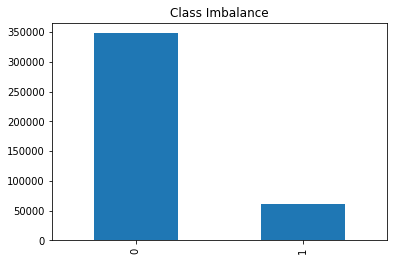

In [99]:
crashes_encoded_2.collision_severity.value_counts().plot(kind='bar', title='Class Imbalance');

In [95]:
la_crashes_encoded_2 = crashes_encoded_2[crashes_encoded_severity.county_location == 'los angeles']
la_crashes_encoded_2.head()

,county_location,collision_time,population,alcohol_involved,weather_1,lighting,road_surface,road_condition_1,state_highway_indicator,type_of_collision,party_count,collision_severity
2,los angeles,10,0,0.0,1,0,1,0,1.0,2,2,0
3,los angeles,15,0,0.0,0,0,0,0,1.0,2,3,0
4,los angeles,17,2,0.0,2,2,0,0,1.0,0,3,0
5,los angeles,21,0,0.0,0,1,0,0,1.0,0,2,0
6,los angeles,20,0,0.0,0,1,0,0,1.0,0,2,0


In [144]:
la_crashes_encoded_2.collision_severity.value_counts()

0    106245
1     17515
Name: collision_severity, dtype: int64

In [141]:
y = la_crashes_encoded_2.collision_severity
la_model_2 = la_crashes_encoded_2.drop(columns=['collision_severity', 'county_location'])
X_train, X_test, y_train, y_test = train_test_split(la_model_2, y, test_size=0.3)

# Create a Random forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
# Train the model using the training sets
rf_clf.fit(X_train, y_train)

Y_pred_rf = rf_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# Display accuracy score
accuracy_score(y_test, Y_pred_rf)

0.8501131221719457

In [142]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
conf_m = confusion_matrix(y_test, Y_pred_rf)
f1_score(y_test, Y_pred_rf), confusion_matrix(y_test, Y_pred_rf), roc_auc_score(y_test, Y_pred_rf)

(0.2085051912956905,
 array([[30830,  1067],
        [ 4498,   733]], dtype=int64),
 0.5533373745702113)

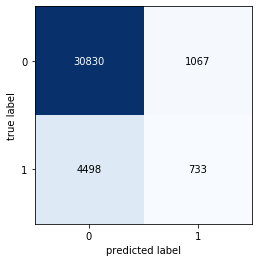

In [143]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

conf_m = confusion_matrix(y_test, Y_pred_rf)

fig, ax = plot_confusion_matrix(conf_mat=conf_m)
plt.show()

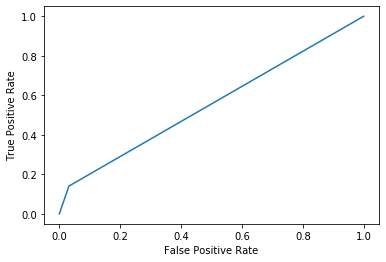

In [121]:
from sklearn import metrics
import matplotlib.pyplot as plt
#define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_rf)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

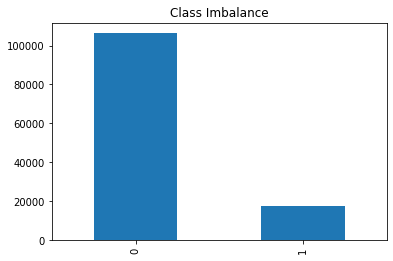

In [102]:
la_crashes_encoded_2.collision_severity.value_counts().plot(kind='bar', title='Class Imbalance');

In [107]:
class_count_0, class_count_1  = la_crashes_encoded_2.collision_severity.value_counts()

In [108]:
class_0 = la_crashes_encoded_2[la_crashes_encoded_2.collision_severity==0]
class_1 = la_crashes_encoded_2[la_crashes_encoded_2.collision_severity==1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (106245, 12)
class 1: (17515, 12)


total class of 1 and 0: 1    17515
0    17515
Name: collision_severity, dtype: int64


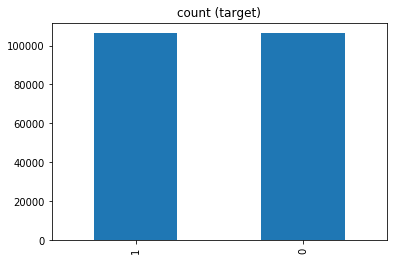

In [123]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_under['collision_severity'].value_counts())# plot the count after under-sampeling
test_over['collision_severity'].value_counts().plot(kind='bar', title='count (target)')

In [148]:
y = test_over.collision_severity
la_model_3 = test_over.drop(columns=['collision_severity', 'county_location'])
X_train, X_test, y_train, y_test = train_test_split(la_model_3, y, test_size=0.3)

# Create a Random forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
# Train the model using the training sets
rf_clf.fit(X_train, y_train)

Y_pred_rf = rf_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# Display accuracy score
accuracy_score(y_test, Y_pred_rf)

0.7468743627151082

In [150]:
f1_score(y_test, Y_pred_rf), confusion_matrix(y_test, Y_pred_rf)

(0.7562758662356885,
 array([[22576,  9224],
        [ 6912, 25035]], dtype=int64))

In [151]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, Y_pred_rf)

0.7467893817059031

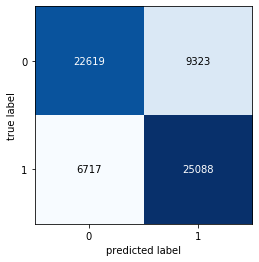

In [140]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

conf_m = confusion_matrix(y_test, Y_pred_rf)

fig, ax = plot_confusion_matrix(conf_mat=conf_m)
plt.show()

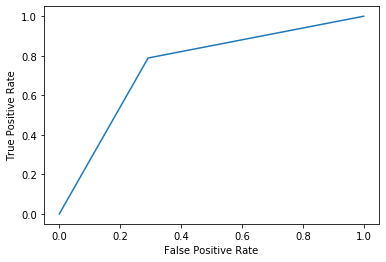

In [129]:
from sklearn import metrics
import matplotlib.pyplot as plt
#define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  Y_pred_rf)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# GeoPandas
- heatmap of crash_severity per county

In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px


In [ ]:
crashes_encoded.head()

In [ ]:
import requests
new_cali = requests.get(
    "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson"
).json()

In [ ]:
for feature in new_cali['features']:
    feature['properties']['name'] = feature['properties']['name'].lower()

In [ ]:
#crash_severity heatmap
fig = px.choropleth(crashes_encoded_severity, featureidkey='properties.name', locations='county_location', geojson=new_cali, color='collision_severity')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

# Trying to map with fips


In [ ]:
#didnt show clearly
fig = px.density_mapbox(crashes_cords, lat='latitude', lon='longitude', z='collision_severity',
                        mapbox_style="stamen-terrain")
 
fig

In [ ]:
#import geopandas
import pandas as pd
#get fip ids for county in the U.S
df_fips = pd.read_csv("https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv",
                   dtype={"fips": str})
df_fips.head()



In [ ]:
#only need fips for California counties
cal_fips = df_fips[df_fips['state'] == 'CA']
cal_fips['name'] = cal_fips['name']
cal_fips = cal_fips.reset_index().drop(['index'], axis=1)
cal_fips.head()


In [ ]:
separator = ' County'
cal_fips['name'] = [county.split(separator, 1)[0].lower() for county in cal_fips['name']] 
cal_fips['fips'] = [('0'+ fip) for fip in  cal_fips['fips'] ]
cal_fips.head()

In [ ]:
crashes_fips = pd.merge(crashes, cal_fips, on='county_location', how='outer')